In [1]:
import chess
import chess.svg
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
import random
from tqdm.notebook import trange

implementing the convolutional Neural network

In [2]:
class ResNet(nn.Module):
    def __init__(self, num_resBlocks, num_hidden, device):
        super().__init__()
        
        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 64)
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 1),
            nn.Tanh()
        )
        
        self.to(device)
     
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x
        

implementing the MCTS algorithm


In [3]:

class Node:
    def __init__(self, state, parent=None,prob=0):
        self.state = state
        self.parent = parent
        self.children = []
        self.visits = 0
        self.wins = 0
        self.prob = prob

    def __str__(self):
        return (f"state : {self.state}\nparent: \nchildren : {self.children}\nvisits : {self.visits}\nwins : {self.wins}\nprior : {self.prob} \n")

    def get_encoded_state(self,state):

        piece_to_index = {'.': 0., 'p': 1., 'r': 5., 'n': 3., 'b': 3., 'q': 9., 'k': 15., 'P': -1. ,'R': -5., 'N': -3.,
                           'B': -3., 'Q': -9., 'K': -15.}
        
        s = []
        x = str(state)
        s.append(x.split('\n'))
        encoded_state = []
        for line in s[0]:
            line = line.split(" ")
            encoded_state.append(line)
        
        for row,row_count in zip(encoded_state,range(len(encoded_state))):
            for piece in piece_to_index:
                row = [piece_to_index[piece] if item == piece else item for item in row]
            encoded_state[row_count]=row

        # print(encoded_state)
        
        return encoded_state
    
    def devide_board_into_channels(self,encoded_board):
          
        return np.stack((np.where(np.asarray(encoded_board)>0,encoded_board,0),
                          np.where(np.asarray(encoded_board)==0,1,0) ,
                          np.where(np.asarray(encoded_board)<0,encoded_board,0)
                        )).astype(np.float32)

def uct_value(node, exploration_weight=1.4):
    if node.visits == 0:
        q_value = 0
    else:
        q_value = 1 - ((node.wins / node.visits) + 1) / 2
    return q_value + exploration_weight * math.sqrt(node.parent.visits / (node.visits + 1)) * node.prob

def select_child(node):
    return max(node.children, key=uct_value)

def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child


def expand_node(node,policy):
    # for action, prob in enumerate(policy):
    legal_moves = list(node.state.legal_moves)
    if not legal_moves:
        return
    
    for move in legal_moves:
        new_state = node.state.copy()
        new_state.push(move)
        # print(f'move : {move}')
        # print(move.to_square)
        prior = extract_policy_from_square(policy, move.to_square)
        new_child = Node(new_state,prob=prior, parent=node)
        node.children.append(new_child)
    return new_child

def extract_policy_from_square(policy,original_board_index):
    """extracts the the policy that represents our move from the flattened list of policies """
    #test = np.flipud(policy)
    o = policy.reshape(1,-1)
    o = o[0,:]
    # print(o)
    # print(o[original_board_index])
    return o[original_board_index]

def backpropagate(node, result):
    while node is not None:
        node.visits += 1
        node.wins += result
        node = node.parent

def is_fully_expanded(node):
    # print(f'list of legal moves {len(list(node.state.legal_moves))}')
    # print(f'node: children {node.children}')
    # print(len(node.children)==len(list(node.state.legal_moves)))
    return len(node.children)==len(list(node.state.legal_moves)) and len(node.children)>0

def encode_result(result_string,player):
    result_mapping = {"1-0": 1, "0-1": -1, "1/2-1/2": 0}
    return result_mapping.get(result_string, None) if player==1 else -result_mapping.get(result_string, None)


In [4]:
class MCTS:
    def __init__(self, initial_state, model, iterations=50, exploration_weight=1.4):
        self.root = Node(initial_state)
        self.exploration_weight = exploration_weight
        self.iterations = iterations
        self.model = model

    @torch.no_grad()
    def search(self):
        
        for _ in range(self.iterations):
            node = self.root

            while is_fully_expanded(node):
                node = select_child(node)
            if node is None:
                backpropagate(node)
            
            policy, value = self.model(
                    torch.tensor(node.devide_board_into_channels(node.get_encoded_state(node.state))).unsqueeze(0)
                )


            policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy() 
            valid_moves = list(node.state.legal_moves)

            valid_moves_in_the_square= self.board_with_valid_moves(valid_moves).reshape(1,-1)
            
            # print(valid_moves_in_the_square[0])
            # print(policy)
            
            policy *= valid_moves_in_the_square[0]
            policy /= np.sum(policy)

            
            value = value.item()

            # value = -value if node.state.turn==False else value
        
            # expand_node(node,policy)
            new_child = expand_node(node,policy)

            # print(f'children nodes after expanding: {node.children}')
            
            if new_child is None:
                #better backpropagate
                continue
            else:
                policy, value = self.model(
                    torch.tensor(node.devide_board_into_channels(node.get_encoded_state(node.state))).unsqueeze(0)
                )
                
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = list(node.state.legal_moves)

                valid_moves_in_the_square= self.board_with_valid_moves(valid_moves).reshape(1,-1)
                
                
                policy *= valid_moves_in_the_square[0]
                policy /= np.sum(policy)

                
                value = value.item()

                # value = -value if node.state.turn==False else value 
            
                # expand_node(node,policy)
                # expandi node w backpropagati ta l values
            backpropagate(node, value) 

        print('###################')
        print('children:')
        [print(child) for child in self.root.children]
        print('___________________')

        children_values = [child.wins for child in self.root.children]
        best_child = select_child(self.root) 

        print(best_child)
        
        # extracting the policy of the root:
        
        policy, value = self.model(
                    torch.tensor(self.root.devide_board_into_channels(self.root.get_encoded_state(self.root.state))).unsqueeze(0)
                )


        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy() 
        valid_moves = list(self.root.state.legal_moves)

        valid_moves_in_the_square= self.board_with_valid_moves(valid_moves).reshape(1,-1)
        
        
        policy *= valid_moves_in_the_square[0]
        policy /= np.sum(policy)

        self.root.children = []
        return best_child.state, children_values, policy

    

    def board_with_valid_moves(self,list_moves):
        empty_board = np.zeros(64)
        for move in list_moves:
            empty_board[move.to_square] = 1 
        empty_board = empty_board.reshape((8,8))
        # print(empty_board)
        return empty_board
    

testing

In [5]:
board = chess.Board("r1b2rk1/ppp2ppp/2n1pn2/3p4/3P4/2N1PN2/PPP2PPP/R1B2RK1 b - - 0 1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet( 6, 64,device=device)
mcts = MCTS(board,model, iterations=200)
best_move ,c,p  = mcts.search()
best_move = best_move.pop()
print(f"Best Move: {best_move}")
board.push(best_move)


###################
children:
state : r . b . . r . k
p p p . . p p p
. . n . p n . .
. . . p . . . .
. . . P . . . .
. . N . P N . .
P P P . . P P P
R . B . . R K .
parent: 
children : [<__main__.Node object at 0x000001FE0EDEE7D0>, <__main__.Node object at 0x000001FE0EDEE950>, <__main__.Node object at 0x000001FE0EDEEAD0>, <__main__.Node object at 0x000001FE0EDEEC90>, <__main__.Node object at 0x000001FE0EDEEF10>, <__main__.Node object at 0x000001FE0EDEF1D0>, <__main__.Node object at 0x000001FE0EDEF450>, <__main__.Node object at 0x000001FE0EDEF6D0>, <__main__.Node object at 0x000001FE0EDEF950>, <__main__.Node object at 0x000001FE0EDEFB90>, <__main__.Node object at 0x000001FE0EDEFE50>, <__main__.Node object at 0x000001FE0EDF4150>, <__main__.Node object at 0x000001FE0EDF4410>, <__main__.Node object at 0x000001FE0EDF46D0>, <__main__.Node object at 0x000001FE0EDF4990>, <__main__.Node object at 0x000001FE0EDF4C50>, <__main__.Node object at 0x000001FE0EDF4F10>, <__main__.Node object at 0x0000

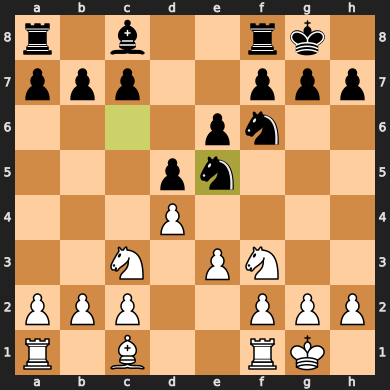

In [6]:
board

In [8]:
p

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03436121, 0.        , 0.09756183, 0.01558312, 0.        ,
       0.02179176, 0.        , 0.07987204, 0.10397681, 0.        ,
       0.        , 0.05625132, 0.        , 0.05630053, 0.06047276,
       0.03518607, 0.04305416, 0.        , 0.        , 0.        ,
       0.        , 0.0516426 , 0.02745926, 0.        , 0.        ,
       0.        , 0.08812739, 0.02324391, 0.        , 0.        ,
       0.        , 0.        , 0.04157147, 0.        , 0.03491716,
       0.07221296, 0.        , 0.        , 0.05641369], dtype=float32)

In [16]:
# best_move ,c,p = mcts.search()
# best_move = best_move.pop()
# print(f"Best Move: {best_move}")
# board.push(best_move)

In [17]:
# board

In [34]:
def get_encoded_state(state):

        piece_to_index = {'.': 0., 'p': 1., 'r': 5., 'n': 3., 'b': 3., 'q': 9., 'k': 15., 'P': -1. ,'R': -5., 'N': -3.,
                           'B': -3., 'Q': -9., 'K': -15.}
        
        s = []
        x = str(state)
        s.append(x.split('\n'))
        encoded_state = []
        for line in s[0]:
            line = line.split(" ")
            encoded_state.append(line)
        
        for row,row_count in zip(encoded_state,range(len(encoded_state))):
            for piece in piece_to_index:
                row = [piece_to_index[piece] if item == piece else item for item in row]
            encoded_state[row_count]=row

        print(encoded_state)
        
        return encoded_state

def devide_board_into_channels(encoded_board):
    return np.stack((np.where(np.asarray(encoded_board)>0,encoded_board,0),
                        np.where(np.asarray(encoded_board)==0,1,0) ,
                        np.where(np.asarray(encoded_board)<0,encoded_board,0)
                    )).astype(np.float32)

implementing the model

In [9]:
class ChadZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        

    def self_play(self):
        ''' this methode is for the model to play a game with itself, it stores the history of
          the game as a fen notation board, the policy history, the player who
        played each move, and the player who won in a list of tupples'''

        #initialize the board
        self.game.reset()
        
        mcts = MCTS(self.game, self.model)
        # print('#################################################################################################')
        # print('#################################################################################################')
        # print('#################################################################################################')
        # print(self.game)
        
        memory = []

        while True:

            best_move, action_value, policy_of_the_state = mcts.search()

            best_move = best_move.pop()
            self.game.push(best_move)

            memory.append((self.game.fen(), policy_of_the_state, int(not self.game.turn)))
            # print('memory so far')
            # print(memory)

            if self.game.is_game_over():
                returnMemory = []
                for state, hist_policy_of_the_state, player_who_played in memory:

                    returnMemory.append((
                        state,
                        hist_policy_of_the_state,
                        player_who_played,
                        encode_result(self.game.result(), player_who_played)
                    ))
                print(returnMemory)
                return returnMemory
                
    def train(self,memory):
        ''' this methode is for the model to train itself, in other words to adjest the CNN's hyperparametters
          so that they can retrieve the optimal policy.
          it wrapps up the memory returned by self.self_play() and proceeds a back propropagate the neural network by adjusting
          the policy throught cross entropy and value by mse loss.'''
        
        random.shuffle(memory) # so that we don't get the same batches over and over
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory), batchIdx + self.args['batch_size'])] 
            state, policy_targets, player_who_played, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state_board = [chess.Board(s) for s in state]

            # print('________________________________________________________')
            # print(state_board)
            # print('________________________________________________________')

            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            data=[]
            
            list_of_encoded_states = [devide_board_into_channels(get_encoded_state(board_state)) for board_state in state_board]

            data.append(list_of_encoded_states)
            data = np.asarray(data)
            # print('________________________________________________________')
            # print(data)
            # print('________________________________________________________')

            
                        
            tensor_states = torch.tensor(np.asarray(*data), dtype=torch.float32, device=self.model.device)

            out_policy, out_value = self.model(tensor_states)

            # print('######################')
            # print('######################')
            # print('######################')
            # print(tensor_states)
            # print(out_policy.size())
            # print(out_policy)
            
            # print(policy_targets.size())
            # print(policy_targets)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            self.optimizer.zero_grad() 
            loss.backward()
            self.optimizer.step() 

    def learn(self):
        ''' simply an iterative methode where we accumulate 
        a batch of play data by invocking self.play inside a 
        loop,the train the model using this load of data'''
        
        for iteration in trange(self.args['num_iterations']):
            memory = []
            print(f"let's start again : {iteration} 🥶")
            
            self.model.eval()
            i=0
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                print("game number "+str(i))
                i+=1
                self.game=chess.Board()
                self.game.reset()
                memory.extend(self.self_play())

            print("let's go training 💪")
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                # print('###########################################################')
                # print('###########################################################')
                # print('###########################################################')
                # print(memory)
                self.train(memory)

            print('saving checkpoints 🤖')
            torch.save(self.model.state_dict(), f"chadzero_params/model_{iteration}_.pt")
            torch.save(self.optimizer.state_dict(), f"chadzero_params/optimizer_{iteration}_.pt")

In [36]:
args = {
    'num_iterations': 4, 
    'num_selfPlay_iterations': 50,
    'num_epochs': 100,
    'batch_size': 1000,
    'learning rate': 0.001,
    'weight_decay': 0.01
}

board0 = chess.Board()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(12, 132, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=args['learning rate'], weight_decay=args['weight_decay'])
# mcts = MCTS(board,model, iterations=20)
chadzero = ChadZero(model=model,optimizer=optimizer,game=board0,args=args)


Best Move: b7b8r


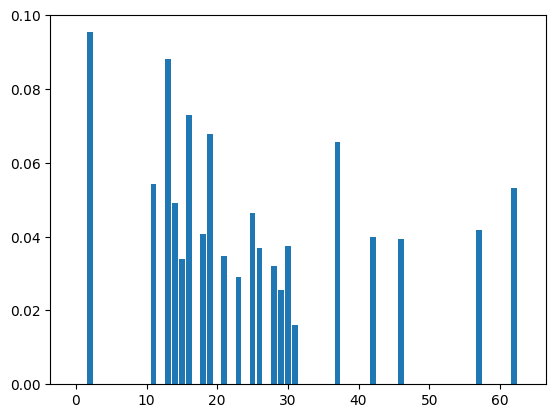

In [27]:
board0= chess.Board("8/1P5B/8/2P5/8/6K1/NkP3p1/RN6")
mcts = MCTS(board0,model, iterations=200)
best_move ,c,p  = mcts.search()
best_move = best_move.pop()
print(f"Best Move: {best_move}")
board0.push(best_move)

import matplotlib.pyplot as plt
plt.bar(range(64), p)
plt.show()


In [9]:
print(model)

ResNet(
  (startBlock): Sequential(
    (0): Conv2d(3, 132, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(132, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (backBone): ModuleList(
    (0-11): 12 x ResBlock(
      (conv1): Conv2d(132, 132, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(132, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(132, 132, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(132, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (policyHead): Sequential(
    (0): Conv2d(132, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=2048, out_features=64, bias=True)
  )
  (valueHead): Sequential(
    (0): Conv2d(13

In [10]:
for name, param in model.named_parameters():
    print(f"Parameter: {name}, Size: {param.size()}")

Parameter: startBlock.0.weight, Size: torch.Size([132, 3, 3, 3])
Parameter: startBlock.0.bias, Size: torch.Size([132])
Parameter: startBlock.1.weight, Size: torch.Size([132])
Parameter: startBlock.1.bias, Size: torch.Size([132])
Parameter: backBone.0.conv1.weight, Size: torch.Size([132, 132, 3, 3])
Parameter: backBone.0.conv1.bias, Size: torch.Size([132])
Parameter: backBone.0.bn1.weight, Size: torch.Size([132])
Parameter: backBone.0.bn1.bias, Size: torch.Size([132])
Parameter: backBone.0.conv2.weight, Size: torch.Size([132, 132, 3, 3])
Parameter: backBone.0.conv2.bias, Size: torch.Size([132])
Parameter: backBone.0.bn2.weight, Size: torch.Size([132])
Parameter: backBone.0.bn2.bias, Size: torch.Size([132])
Parameter: backBone.1.conv1.weight, Size: torch.Size([132, 132, 3, 3])
Parameter: backBone.1.conv1.bias, Size: torch.Size([132])
Parameter: backBone.1.bn1.weight, Size: torch.Size([132])
Parameter: backBone.1.bn1.bias, Size: torch.Size([132])
Parameter: backBone.1.conv2.weight, Size: 

In [28]:
board0 = chess.Board()

In [37]:
chadzero.learn()

  0%|          | 0/4 [00:00<?, ?it/s]

let's start again : 0 🥶


  0%|          | 0/50 [00:00<?, ?it/s]

game number 0
[('8/1P6/6B1/2P5/8/6K1/NkP3p1/RN6 b - - 1 1', array([0.        , 0.        , 0.05164243, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04948334, 0.        , 0.04251123, 0.04489752,
       0.04812669, 0.04404079, 0.        , 0.04204273, 0.04466144,
       0.        , 0.03932378, 0.        , 0.0556611 , 0.        ,
       0.04692836, 0.0442098 , 0.        , 0.05498947, 0.04589103,
       0.04448078, 0.04641886, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0531129 , 0.        , 0.        ,
       0.        , 0.        , 0.03788323, 0.        , 0.        ,
       0.        , 0.0710898 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04066994, 0.        , 0.        ,
       0.        , 0.        , 0.05193472, 0.        ], dtype=float32), 1, 0), ('8/1P6/6B1/2P5/8/6K1/NkP5/RN4r1 w - - 0 2', array([0.431

KeyboardInterrupt: 

In [20]:
# a = chadzero.self_play()

C:\Users\HP\AppData\Local\Temp\ipykernel_11296\403109923.py:33: RuntimeWarning: invalid value encountered in divide
  policy /= np.sum(policy)


[('rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR b KQkq - 0 1', array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05961659, 0.09795576, 0.07685474, 0.03078455,
       0.03486839, 0.09472133, 0.05961091, 0.04567015, 0.03792153,
       0.02563896, 0.05718594, 0.07990801, 0.121743  , 0.06412962,
       0.05970518, 0.05368533, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32), 1, -1), ('rnbqkbnr/ppppppp1/7p/8/8/1P6/P1PPPPPP/RNBQKBNR w K

In [ ]:
model.load_state_dict(torch.load("chadzero_params/model_1_.pt", map_location=device))
model.eval()

board0= chess.Board()
mcts = MCTS(board0,model, iterations=50)
best_move ,c,p  = mcts.search()
best_move = best_move.pop()
print(f"Best Move: {best_move}")
board0.push(best_move)

import matplotlib.pyplot as plt
plt.bar(range(64), p)
plt.show()


KeyboardInterrupt: 

In [13]:
def run_experiment(current_config):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet(12, 132, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    # mcts = MCTS(board,model, iterations=20)
    chadzero = ChadZero(model=model,optimizer=optimizer,game=board,args=current_config)

    chadzero.learn()

    fight_a_random(chadzero.model)

def fight_a_random(model):

    winner = []
    while len(winner)<100:

        board = chess.Board()
        mcts = MCTS(board,model, iterations=50)
        while not board.is_game_over:
            move = random(list(board.legal_moves))

            board.push(move)

            if board.is_game_over:
                winner.append(encode_result(board))
                break
            
            best_move ,c,p  = mcts.search()
            best_move = best_move.pop()
            board.push(best_move)

            if board.is_game_over:
                winner.append(encode_result(board))
                break
        
    return winner.count(-1)/100


In [16]:
from itertools import product

# Define the hyperparameter grid
hyperparameter_grid = {
    'num_iterations': [4,40,400], 
    'num_selfPlay_iterations': 50,
    'num_epochs': [100,500,1000],
    'batch_size': [1000,1500,2000],
}


best_hyperparameters = None
best_metric = float('-inf')  


for hyperparameters in product(hyperparameter_grid.values()):
    print(hyperparameters)

    current_config = dict(zip(hyperparameter_grid.keys(), hyperparameters))


    metric = run_experiment(current_config)


    print(f"Hyperparameters: {current_config}, Metric: {metric}")

    # Check if the current configuration improves the best metric
    if metric > best_metric:
        best_metric = metric
        best_hyperparameters = current_config

# Print the best hyperparameters and corresponding metric
print(f"\nBest Hyperparameters: {best_hyperparameters}, Best Metric: {best_metric}")